In [1]:
import torch
import tqdm
import torch.nn.functional as F
from torch import nn

import matplotlib.pyplot as plt

from hydra import initialize, compose
from hydra.utils import instantiate
import pytorch_lightning
from pytorch_lightning.utilities import move_data_to_device

from bliss.surveys.dc2 import DC2DataModule
from bliss.catalog import TileCatalog
from bliss.global_env import GlobalEnv

In [2]:
with initialize(config_path="./", version_base=None):
    new_diffusion_notebook_cfg = compose("notebook_config")
    new_diffusion_notebook_cfg.surveys.dc2.num_workers = 8

In [3]:
seed = 7272
pytorch_lightning.seed_everything(seed=seed)
GlobalEnv.seed_in_this_program = seed
device = torch.device("cuda:7")
train_epochs = 1
log_freq = 10

Seed set to 7272


In [4]:
class SimpleSetTransformer(nn.Module):
    def __init__(self, in_dim, hidden_dim, inter_layers, out_dim):
        super().__init__()
        self.input_linear = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.SiLU(),
        )
        self.inter_layers = nn.ModuleList([])
        for _ in range(inter_layers):
            self.inter_layers.append(nn.ModuleList([
                nn.MultiheadAttention(hidden_dim, num_heads=4, batch_first=True),
                nn.LayerNorm(hidden_dim),
                nn.Sequential(nn.Linear(hidden_dim, hidden_dim * 2),
                            nn.SiLU(),
                            nn.Linear(hidden_dim * 2, hidden_dim)),
                nn.LayerNorm(hidden_dim)
            ]))
        self.output_linear = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, x):
        x = self.input_linear(x)
        for mha, ln1, ff, ln2 in self.inter_layers:
            x = ln1(mha(x, x, x)[0] + x)
            x = ln2(ff(x) + x)
        return self.output_linear(x)

In [5]:
batch_size = 1024
dc2: DC2DataModule = instantiate(new_diffusion_notebook_cfg.surveys.dc2)
dc2.batch_size = batch_size
dc2.setup(stage="fit")

In [6]:
b_net = SimpleSetTransformer(in_dim=8, hidden_dim=64, inter_layers=6, out_dim=1).to(device=device)
my_optimizer = torch.optim.Adam(b_net.parameters(), lr=1e-3, amsgrad=True)
my_scheduler = torch.optim.lr_scheduler.MultiStepLR(my_optimizer, milestones=[train_epochs // 3 * 2])

In [7]:
def get_xy_from_full_cat(full_cat):
    plocs = full_cat["plocs"]  # (b, n, 2)
    fluxes = full_cat["fluxes"]  # (b, n, 6)
    mask = full_cat.is_on_mask.unsqueeze(-1)  # (b, n, 1)
    plocs = torch.where(mask, plocs, -1.0)
    fluxes = torch.where(mask, fluxes, -1.0)
    if "blendedness" in full_cat:
        y = full_cat["blendedness"]  # (b, n, 1)
        y_mask = mask & ~(full_cat["blendedness"].isnan())
        y = torch.where(y_mask, y, -1.0)
    else:
        y_mask = None
        y = None
    x = torch.cat([plocs, fluxes], dim=-1)  # (b, n, 8)
    return x, y, y_mask

In [8]:
b_net = b_net.train()
training_losses = []
for epoch_i in range(train_epochs):
    GlobalEnv.current_encoder_epoch = epoch_i
    dc2_train_dataloader = dc2.train_dataloader()
    loop = tqdm.tqdm(enumerate(dc2_train_dataloader), 
                     total=len(dc2_train_dataloader), 
                     desc=f"Epoch {epoch_i + 1}")
    for step_i, one_batch in loop:
        one_batch = move_data_to_device(one_batch, device=device)
        true_full_cat = TileCatalog(one_batch["tile_catalog"]).to_full_catalog(tile_slen=4)
        x, y, y_mask = get_xy_from_full_cat(true_full_cat)
        my_optimizer.zero_grad()
        pred_blendedness = b_net(x)
        loss = (pred_blendedness - y) ** 2 * y_mask.float() # * torch.where(y_mask, (y + 1e-3) * 1000, 0.0)
        loss = loss.mean()
        loss.backward()
        my_optimizer.step()
        training_losses.append(loss.item())
        if (step_i + 1) % log_freq == 0:
            loop.write(f"[Epoch {epoch_i + 1}; Step {step_i + 1}] loss: {loss.item():.3e}")
    my_scheduler.step()

Epoch 1:   5%|▌         | 10/191 [00:21<07:04,  2.35s/it]

[Epoch 1; Step 10] loss: 7.418e-03


Epoch 1:  10%|█         | 20/191 [00:32<03:49,  1.34s/it]

[Epoch 1; Step 20] loss: 3.845e-03


Epoch 1:  16%|█▌        | 30/191 [00:44<02:05,  1.28it/s]

[Epoch 1; Step 30] loss: 2.834e-03


Epoch 1:  21%|██        | 40/191 [00:54<01:12,  2.09it/s]

[Epoch 1; Step 40] loss: 3.016e-03


Epoch 1:  26%|██▌       | 50/191 [01:12<04:07,  1.76s/it]

[Epoch 1; Step 50] loss: 2.771e-03


Epoch 1:  31%|███▏      | 60/191 [01:26<03:28,  1.59s/it]

[Epoch 1; Step 60] loss: 4.240e-03


Epoch 1:  37%|███▋      | 70/191 [01:38<02:10,  1.07s/it]

[Epoch 1; Step 70] loss: 2.933e-03


Epoch 1:  42%|████▏     | 80/191 [01:51<01:24,  1.31it/s]

[Epoch 1; Step 80] loss: 2.713e-03


Epoch 1:  47%|████▋     | 90/191 [02:04<01:01,  1.63it/s]

[Epoch 1; Step 90] loss: 2.254e-03


Epoch 1:  52%|█████▏    | 100/191 [02:27<05:00,  3.30s/it]

[Epoch 1; Step 100] loss: 1.915e-03


Epoch 1:  58%|█████▊    | 110/191 [02:40<02:35,  1.92s/it]

[Epoch 1; Step 110] loss: 2.144e-03


Epoch 1:  63%|██████▎   | 120/191 [02:53<01:13,  1.04s/it]

[Epoch 1; Step 120] loss: 3.095e-03


Epoch 1:  68%|██████▊   | 130/191 [03:06<00:36,  1.68it/s]

[Epoch 1; Step 130] loss: 2.810e-03


Epoch 1:  73%|███████▎  | 140/191 [03:26<02:31,  2.97s/it]

[Epoch 1; Step 140] loss: 2.910e-03


Epoch 1:  79%|███████▊  | 150/191 [03:37<01:04,  1.57s/it]

[Epoch 1; Step 150] loss: 2.855e-03


Epoch 1:  84%|████████▍ | 160/191 [03:47<00:26,  1.15it/s]

[Epoch 1; Step 160] loss: 3.848e-03


Epoch 1:  89%|████████▉ | 170/191 [03:58<00:10,  1.93it/s]

[Epoch 1; Step 170] loss: 3.061e-03


Epoch 1:  94%|█████████▍| 180/191 [04:16<00:28,  2.59s/it]

[Epoch 1; Step 180] loss: 4.260e-03


Epoch 1:  99%|█████████▉| 190/191 [04:31<00:02,  2.58s/it]

[Epoch 1; Step 190] loss: 4.188e-03


Epoch 1: 100%|██████████| 191/191 [04:32<00:00,  1.43s/it]


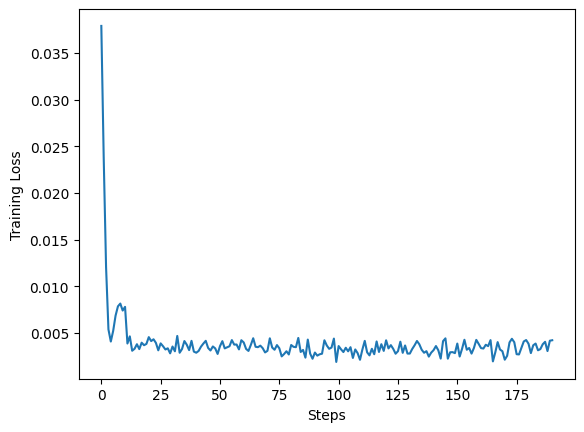

In [9]:
plt.plot(training_losses)
# plt.yscale("log")
plt.ylabel("Training Loss")
plt.xlabel("Steps")
plt.show()

In [10]:
dc2.setup(stage="validate")
dc2_val_dataloader = dc2.val_dataloader()

In [11]:
b_net = b_net.eval()
n_sources_list = []
ori_blendedness = []
new_blendedness = []
for one_batch in tqdm.tqdm(dc2_val_dataloader):
    one_batch = move_data_to_device(one_batch, device=device)
    target_full_cat = TileCatalog(one_batch["tile_catalog"]).to_full_catalog(tile_slen=4)
    x = get_xy_from_full_cat(target_full_cat)[0]
    with torch.inference_mode():
        target_full_cat["new_blendedness"] = b_net(x)
    target_tile_cat = target_full_cat.to_tile_catalog(tile_slen=4, max_sources_per_tile=5).get_brightest_sources_per_tile()
    n_sources_list.append(((target_tile_cat["n_sources"] > 0) & ~(target_tile_cat["blendedness"].isnan()).squeeze()).cpu())
    ori_blendedness.append(target_tile_cat["blendedness"].cpu())
    new_blendedness.append(target_tile_cat["new_blendedness"].cpu())
n_sources_list = torch.cat(n_sources_list, dim=0)
ori_blendedness = torch.cat(ori_blendedness, dim=0)
new_blendedness = torch.cat(new_blendedness, dim=0)

100%|██████████| 25/25 [00:16<00:00,  1.51it/s]


In [12]:
n_sources_list.shape, ori_blendedness.shape, new_blendedness.shape

(torch.Size([25000, 20, 20]),
 torch.Size([25000, 20, 20, 1, 1]),
 torch.Size([25000, 20, 20, 1, 1]))

In [13]:
ori_blendedness = ori_blendedness.squeeze()
new_blendedness = new_blendedness.squeeze()

In [14]:
ori_blendedness.shape, new_blendedness.shape

(torch.Size([25000, 20, 20]), torch.Size([25000, 20, 20]))

In [15]:
ori_blendedness = ori_blendedness[n_sources_list]
new_blendedness = new_blendedness[n_sources_list]

In [16]:
ori_blendedness.shape, new_blendedness.shape

(torch.Size([139609]), torch.Size([139609]))

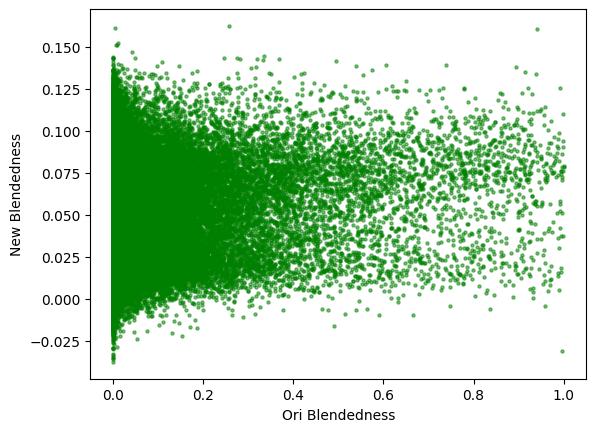

In [17]:
plt.scatter(ori_blendedness, new_blendedness, s=5, alpha=0.5, c="green")
plt.xlabel("Ori Blendedness")
plt.ylabel("New Blendedness")
plt.show()

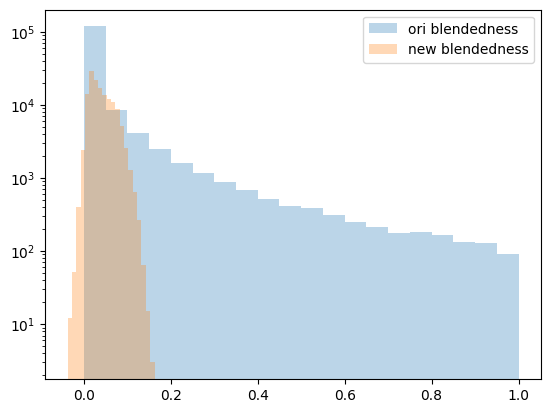

In [18]:
plt.hist(ori_blendedness, bins=20, density=False, log=True, alpha=0.3, label="ori blendedness")
plt.hist(new_blendedness, bins=20, density=False, log=True, alpha=0.3, label="new blendedness")
plt.legend()
plt.show()

In [19]:
bin_cutoffs = torch.tensor([0.02, 0.3, 0.5, 0.7, 0.9])
print(torch.bincount(torch.bucketize(ori_blendedness, bin_cutoffs)))
print(torch.bincount(torch.bucketize(new_blendedness, bin_cutoffs)))

tensor([104899,  30184,   2498,   1149,    658,    221])
tensor([ 38251, 101358])


In [20]:
torch.corrcoef(torch.stack([ori_blendedness, new_blendedness], dim=0))

tensor([[1.0000, 0.2050],
        [0.2050, 1.0000]])